# Requirements

In [138]:
import pandas as pd

In [139]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [140]:
# !gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe # Download the dataset.

#lstm features od minatoto do segasnosta

## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [141]:
# Write your code here. Add as many boxes as you need.
df = pd.read_csv("./website-visitors.csv")


In [142]:
df.head(5)

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0


In [143]:
quantitative_features = list(df.select_dtypes(include=["number"]))
quantitative_features

['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']

In [144]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)

In [145]:
df.head(5)

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2014-09-14,Sunday,2.146,1.582,1.430,152.0
2014-09-15,Monday,3.621,2.528,2.297,231.0
2014-09-16,Tuesday,3.698,2.630,2.352,278.0
2014-09-17,Wednesday,3.667,2.614,2.327,287.0
2014-09-18,Thursday,3.316,2.366,2.130,236.0


In [146]:
def grouped_corr(df: pd.DataFrame):
    for cat in df.select_dtypes(include=['object', 'category']):
        for num in df.select_dtypes(include=['number']):
            print(cat+"--->"+num)
            print("####")
            print(df.groupby(cat)[num].mean())
            print("####")
            print()

In [147]:
grouped_corr(df)

day_of_week--->page_loads
####
day_of_week
Friday       3.719861
Monday       4.845681
Saturday     2.501026
Sunday       3.246981
Thursday     4.651356
Tuesday      4.955335
Wednesday    4.893916
Name: page_loads, dtype: float64
####

day_of_week--->unique_visits
####
day_of_week
Friday        8.091159
Monday        3.458426
Saturday     48.688019
Sunday       14.251929
Thursday      8.316087
Tuesday       3.539294
Wednesday     9.631361
Name: unique_visits, dtype: float64
####

day_of_week--->first_time_visits
####
day_of_week
Friday         9.212379
Monday        11.111210
Saturday     116.656385
Sunday        51.615439
Thursday      12.226502
Tuesday       12.025577
Wednesday     13.420439
Name: first_time_visits, dtype: float64
####

day_of_week--->returning_visits
####
day_of_week
Friday       482.352751
Monday       600.245161
Saturday     309.566343
Sunday       392.245161
Thursday     580.236246
Tuesday      611.061290
Wednesday    603.183987
Name: returning_visits, dtype: flo

<Axes: >

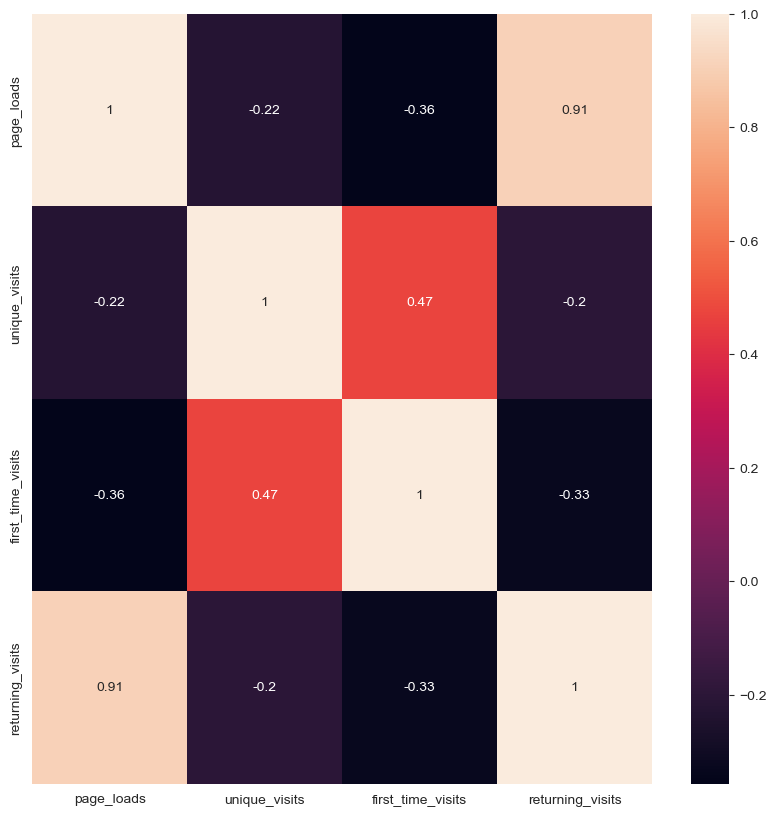

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(df[quantitative_features].corr(),annot=True)

Explore the dataset using visualizations of your choice.

In [149]:
# Write your code here. Add as many boxes as you need.

Encode the categorical features.

In [150]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    df_copy = dataframe.copy()
    for column in columns:
        le = LabelEncoder()
        mask = df_copy[column].isnull()
        df_copy[column] = le.fit_transform(df_copy[column].astype(str))
        df_copy.loc[mask, column] = None
    return df_copy

In [151]:
df = label_encoder(df,["day_of_week"])

In [152]:
df.sample(5)

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2017-06-23,0.0,2.469,1.850,1.445,405.0
2015-05-23,2.0,2.618,1.884,1.585,299.0
2016-11-13,3.0,4.365,3.172,2.595,577.0
2019-08-11,3.0,2.082,1.502,1.242,260.0
2017-02-10,0.0,4.044,2.922,2.335,587.0


# Feauture Extraction
Apply a lag of one, two, and three days to each chosen feature (except `day_of_week`), creating a set of features representing the statistics from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [153]:
def shift_columns(df:pd.DataFrame,columns:list[str],n:int):
    df_copy = df.copy(deep=True)
    for column in columns:
        for i in range(1, n+1):
            df_copy[f'{column}_shifted_{i}'] = df_copy[column].shift(i)
    return df_copy

In [154]:
df = shift_columns(df,quantitative_features,3)

In [155]:
df.dropna(axis=0,inplace=True)
df

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits,page_loads_shifted_1,page_loads_shifted_2,page_loads_shifted_3,unique_visits_shifted_1,unique_visits_shifted_2,unique_visits_shifted_3,first_time_visits_shifted_1,first_time_visits_shifted_2,first_time_visits_shifted_3,returning_visits_shifted_1,returning_visits_shifted_2,returning_visits_shifted_3
date,,,,,,,,,,,,,,,,,
2014-09-17,6.0,3.667,2.614,2.327,287.0,3.698,3.621,2.146,2.630,2.528,1.582,2.352,2.297,1.430,278.0,231.0,152.0
2014-09-18,4.0,3.316,2.366,2.130,236.0,3.667,3.698,3.621,2.614,2.630,2.528,2.327,2.352,2.297,287.0,278.0,231.0
2014-09-19,0.0,2.815,1.863,1.622,241.0,3.316,3.667,3.698,2.366,2.614,2.630,2.130,2.327,2.352,236.0,287.0,278.0
2014-09-20,2.0,1.658,1.118,985.000,133.0,2.815,3.316,3.667,1.863,2.366,2.614,1.622,2.130,2.327,241.0,236.0,287.0
2014-09-21,3.0,2.288,1.656,1.481,175.0,1.658,2.815,3.316,1.118,1.863,2.366,985.000,1.622,2.130,133.0,241.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,2.0,2.221,1.696,1.373,323.0,2.971,3.621,3.767,2.308,2.780,2.904,1.922,2.322,2.477,386.0,458.0,427.0
2020-08-16,3.0,2.724,2.037,1.686,351.0,2.221,2.971,3.621,1.696,2.308,2.780,1.373,1.922,2.322,323.0,386.0,458.0
2020-08-17,1.0,3.456,2.638,2.181,457.0,2.724,2.221,2.971,2.037,1.696,2.308,1.686,1.373,1.922,351.0,323.0,386.0


In [156]:
X,y = df.drop(columns=quantitative_features,axis=1),df["page_loads"]

In [157]:
X

,day_of_week,page_loads_shifted_1,page_loads_shifted_2,page_loads_shifted_3,unique_visits_shifted_1,unique_visits_shifted_2,unique_visits_shifted_3,first_time_visits_shifted_1,first_time_visits_shifted_2,first_time_visits_shifted_3,returning_visits_shifted_1,returning_visits_shifted_2,returning_visits_shifted_3
date,,,,,,,,,,,,,
2014-09-17,6.0,3.698,3.621,2.146,2.630,2.528,1.582,2.352,2.297,1.430,278.0,231.0,152.0
2014-09-18,4.0,3.667,3.698,3.621,2.614,2.630,2.528,2.327,2.352,2.297,287.0,278.0,231.0
2014-09-19,0.0,3.316,3.667,3.698,2.366,2.614,2.630,2.130,2.327,2.352,236.0,287.0,278.0
2014-09-20,2.0,2.815,3.316,3.667,1.863,2.366,2.614,1.622,2.130,2.327,241.0,236.0,287.0
2014-09-21,3.0,1.658,2.815,3.316,1.118,1.863,2.366,985.000,1.622,2.130,133.0,241.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,2.0,2.971,3.621,3.767,2.308,2.780,2.904,1.922,2.322,2.477,386.0,458.0,427.0
2020-08-16,3.0,2.221,2.971,3.621,1.696,2.308,2.780,1.373,1.922,2.322,323.0,386.0,458.0
2020-08-17,1.0,2.724,2.221,2.971,2.037,1.696,2.308,1.686,1.373,1.922,351.0,323.0,386.0


In [158]:
y

date
2014-09-17    3.667
2014-09-18    3.316
2014-09-19    2.815
2014-09-20    1.658
2014-09-21    2.288
              ...  
2020-08-15    2.221
2020-08-16    2.724
2020-08-17    3.456
2020-08-18    3.581
2020-08-19    2.064
Name: page_loads, Length: 2164, dtype: float64

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [159]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)


## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [160]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

RandomForestRegressor(random_state=42)

Use the trained model to make predictions for the test set.

In [161]:
pred_y = model.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [162]:
from sklearn.metrics import r2_score

# Write your code here. Add as many boxes as you need.
r2_score(test_y, pred_y)

0.9010951856195695

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [163]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Use the trained model to make predictions for the test set.

In [164]:
pred_y = xgb.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [165]:
r2_score(test_y, pred_y)

0.8689151494914897

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [166]:
# Write your code here. Add as many boxes as you need.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [167]:
from sklearn.model_selection import TimeSeriesSplit

params = {
    'n_estimators': [100, 200, 300],
}

cv = TimeSeriesSplit(n_splits=5)

In [168]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=cv, scoring='neg_mean_squared_error')

grid.fit(train_X,train_y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [169]:
model = grid.best_estimator_


## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [170]:
pred_y = model.predict(test_X)


In [171]:
r2_score(test_y, pred_y)


0.8954514818170852